In [1]:
import folium 
import numpy as np 
import matplotlib.pyplot as plt
import random as rd 
import requests
import json 
from folium import plugins
from folium.plugins import HeatMap
import time 
from networkx import DiGraph
from vrpy import VehicleRoutingProblem
import random as rd 
from time import * 

In [3]:
def dist(u,v):
    return ((v[0]-u[0])**2 + (u[1]-v[1])**2)**0.5


def distanceGPS(A,B):
    """Retourne la distance en mètres entre les 2 points A et B connus grâce à
       leurs coordonnées GPS (en radians).
    """
    # Rayon de la terre en mètres (sphère IAG-GRS80)
    latA = 2*np.pi*A[0]/360
    longA = 2*np.pi*A[1]/360
    latB = 2*np.pi*B[0]/360
    longB = 2*np.pi*B[1]/360
    RT = 6378137
    # angle en radians entre les 2 points
    S = 2*np.sqrt(np.sin((latB-latA)/2)**2+np.cos(latA)*np.cos(latB)*np.sin((longB-longA)/2)**2)
    # S = np.arccos(np.sin(latA)*np.sin(latB) + np.cos(latA)*np.cos(latB)*np.cos(abs(longB-longA)))
    # distance entre les 2 points, comptée sur un arc de grand cercle
    return S*RT

    
def change(way, dmax, dmin, h): #
    """
    dmax c'est la distance maximale autorisée entre deux points : si est dépassé, on en crée de nouveaux
    dmin c'est l'inverse : on détruit un point. h c'est la distance optimale, entre les deux.   
    """
    N = len(way)
    c = 0 #C'est l'indice courant, on se déplace le long du chemin.
    while c+1 != N: 
        D = dist(way[c],way[c+1]) #Distance between start and arrival  
        x1, y1 = way[c]
        x2, y2 = way[c+1]
        if D > dmax: 
            x = (h/D)*(x2 - x1) + x1
            y = (h/D)*(y2 - y1) + y1
            way.insert(c+1, [x,y])
            c += 1
        elif D < dmin : 
            way.pop(c+1)
        else : 
            c += 1
        N = len(way)
    return way 


def route_dect(itineraire): 
    """
    Cette fonction nous permet de connaître toutes les routes de notre itinéraire. 
    Chacun de ces éléments correspond à une liste qui définit une route : noeud de début, noeud d'arrivée (en coordonnées)
    """
    theta = 0 
    N = len(itineraire)
    routes = [[itineraire[0]]] # Chaque élément de routes est une route, avec un point de départ, et un point d'arrivée. 
    for k in range(N-2):
        a = distanceGPS(itineraire[k+2], itineraire[k+1])
        b = distanceGPS(itineraire[k+2], itineraire[k])
        c = distanceGPS(itineraire[k], itineraire[k+1]) 
        try :
            theta = round(np.arccos((a**2 - b**2 - c**2)/(-2*b*c))*360/(2*np.pi))

        except ValueError:
            theta = 0
        if theta >= 35 : #cela signifie que le prochain point est le départ d'une nouvelle route. 
            routes.append([])
            routes[-1].append(itineraire[k+1]) #On ouvre une nouvelle route 
            routes[-2].append(itineraire[k]) #Et on ferme l'ancienne 
    return routes 

        

In [4]:
def find_nodes(coordinates, N, d): 
    """
    C'est la fonction que l'on va utiliser pour trouver toutes les noeuds dans un espace donné. 
    N c'est le nombre d'itinéraires que l'on va faire pour trouver tous ces noeuds. 

    """ 
    x_min = coordinates[0][0]
    x_max = coordinates[1][0]
    y_min = coordinates[0][1]
    y_max = coordinates[1][1]
    Delta_x = x_max-x_min
    Delta_y = y_max-y_min

    nodes = {}

    T = [] # C'est la liste des temps qui pour le moment est vide : dès que l'on trouve un nouveau point, on ajoute un temps
    Y = [] # C'est la liste du nombre de points trouvés : dès que l'on en trouve un, on ajoute un élément. 

    T_init = time()
    courant = 1 #C'est l'indice courant du noeud que l'on ajoute. 
    for k in range(N): 
        print((k/N)*100)
        start_x = x_min + Delta_x*rd.random()
        start_y = y_min + Delta_x*rd.random()
        end_x = x_min + Delta_x*rd.random()
        end_y = y_min + Delta_x*rd.random()
        texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_y) + "," + str(start_x) + "&end=" + str(end_y) + "," + str(end_x) + "&timeUnit=second")
        texte = json.loads(texte.text)
        itineraire = texte['geometry']['coordinates']
        for el in itineraire:
            i=el[0]
            el[0]=el[1]
            el[1]=i
        itineraire = change(itineraire, 0.000125/3, 0.00005*(2/3), 0.0001125/3)
        routes = route_dect(itineraire)
        noeuds_courant = []
        noeuds_potentiel = []
        if len(routes) !=1 and len(routes)!=2 : #S'il n'y a qu'une seule route il n'y a pas de noeuds qui nous intéressent
            for route in routes[1:len(routes)-1] : 
                #if distanceGPS(route[0], route[1]) >= 70: 
                noeuds_courant.append(route[0])
            for noeud in noeuds_courant : 
                if len(nodes) !=0 :
                    d_min = 1000
                    for node in nodes : 
                        if distanceGPS(nodes[node], noeud) <= d_min: 
                            d_min = distanceGPS(nodes[node], noeud)
                    if d_min >= d: 
                        noeuds_potentiel.append(noeud)
                        Temps = time()
                        T.append(Temps-T_init)
                        Y.append(len(T))
                else : 
                    noeuds_potentiel.append(noeud)
                    Temps = time()
                    T.append(Temps-T_init)
                    Y.append(len(T))
            for noeud in noeuds_potentiel: 
                nodes[str(courant)] = noeud
                courant += 1
        #print(nodes)
    return nodes, routes, itineraire, T, Y

In [5]:
def draw(noeuds, coordinates): 
    map = folium.Map(location=coordinates[0],zoom_start= 15)
    if type(noeuds) == dict: 
        for noeud in noeuds : 
            folium.Circle(location=noeuds[noeud], radius = 6, color = 'red').add_to(map)
    elif type(noeuds) == list: 
        for noeud in noeuds:
            folium.Circle(location=noeud, radius = 6, color = 'blue').add_to(map) 
    return map 


#UN EXEMPLE POUR TESTER QUE LES NOEUDS SONT BIEN DESSINÉS
nodes = {
    "0" : [48.84398020138173, 2.3389824418286684],
    "1" : [48.84391289824998, 2.3403395331628376],
    "2" : [48.84341388446145, 2.3415467019533205], 
    "3" : [48.84440778257574, 2.3420470955437263], 
    "4" : [48.84493806731674, 2.342361100721097], 
    "5" : [48.84626690825651, 2.3402599073836177], 
    "6" : [48.84603453758731, 2.341192794862878], 
    "7" : [48.84561265831214, 2.3427475462260468], 
    "8" : [48.846644247652264, 2.3416611494837696],
    "9" : [48.84643800878857, 2.3425796369204495], 
    "10" : [48.846103991165215, 2.343000254945767], 
    "11" : [48.84728104166769, 2.34060171018991], 
    "12" : [48.847129234485, 2.341971223536511], 
    "13" : [48.84690753608959, 2.342829751948107], 
    "14" : [48.846818141299046, 2.3433405220004384]
        }

In [281]:
Noeuds, routes, itineraire, T, Y = find_nodes([nodes['0'], [48.85770026735891, 2.360802362883455]], 1500, d = 50)
map_noeuds = draw(Noeuds, [nodes['0'], [48.85770026735891, 2.360802362883455]])
map_iti = draw(itineraire, [nodes['0'], [48.85770026735891, 2.360802362883455]])
folium.PolyLine(routes).add_to(map_iti)
print("On a trouvé " + str(len(Noeuds)) + " noeuds")
map_noeuds

0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.33333333333333337
0.4
0.46666666666666673
0.5333333333333333
0.6
0.6666666666666667
0.7333333333333333
0.8
0.8666666666666666
0.9333333333333335
1.0
1.0666666666666667
1.1333333333333333
1.2
1.2666666666666666
1.3333333333333335
1.4000000000000001
1.4666666666666666
1.5333333333333332
1.6
1.6666666666666667
1.7333333333333332
1.7999999999999998
1.866666666666667
1.9333333333333333
2.0
2.0666666666666664
2.1333333333333333
2.1999999999999997
2.2666666666666666
2.3333333333333335
2.4
2.466666666666667
2.533333333333333
2.6
2.666666666666667
2.7333333333333334
2.8000000000000003
2.8666666666666667
2.933333333333333
3.0
3.0666666666666664
3.1333333333333333
3.2
3.266666666666666
3.3333333333333335
3.4000000000000004
3.4666666666666663
3.5333333333333337
3.5999999999999996
3.6666666666666665
3.733333333333334
3.8
3.8666666666666667
3.933333333333333
4.0
4.066666666666666
4.133333333333333
4.2
4.266666666666667
4.333333333

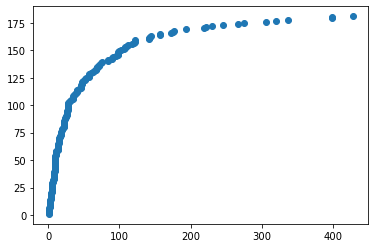

In [282]:
plt.scatter(T, Y)

In [6]:
Noeuds, routes, itineraire, T, Y= find_nodes([nodes['0'], [48.84979855534378, 2.3489792236070093]], 300, d = 35)
map_noeuds = draw(Noeuds, [nodes['0'], [48.84979855534378, 2.3489792236070093]])
print("On a trouvé " + str(len(Noeuds)) + " noeuds")
map_noeuds

0.0
0.33333333333333337
0.6666666666666667
1.0
1.3333333333333335
1.6666666666666667
2.0
2.3333333333333335
2.666666666666667
3.0
3.3333333333333335
3.6666666666666665
4.0
4.333333333333334
4.666666666666667
5.0
5.333333333333334
5.666666666666666
6.0
6.333333333333334
6.666666666666667
7.000000000000001
7.333333333333333
7.666666666666666
8.0
8.333333333333332
8.666666666666668
9.0
9.333333333333334
9.666666666666666
10.0
10.333333333333334
10.666666666666668
11.0
11.333333333333332
11.666666666666666
12.0
12.333333333333334
12.666666666666668
13.0
13.333333333333334
13.666666666666666
14.000000000000002
14.333333333333334
14.666666666666666
15.0
15.333333333333332
15.666666666666668
16.0
16.333333333333332
16.666666666666664
17.0
17.333333333333336
17.666666666666668
18.0
18.333333333333332
18.666666666666668
19.0
19.333333333333332
19.666666666666664
20.0
20.333333333333332
20.666666666666668
21.0
21.333333333333336
21.666666666666668
22.0
22.333333333333332
22.666666666666664
23.0


In [287]:
Noeuds, routes, itineraire, T, Y = find_nodes([nodes['0'], [48.867322280587096, 2.363096655797159]], 3000, d = 50)
map_noeuds = draw(Noeuds, [nodes['0'], [48.867322280587096, 2.363096655797159]])
map_iti = draw(itineraire, [nodes['0'], [48.867322280587096, 2.363096655797159]])
folium.PolyLine(routes).add_to(map_iti)
print("On a trouvé " + str(len(Noeuds)) + " noeuds")
map_noeuds

0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666669
0.2
0.23333333333333336
0.26666666666666666
0.3
0.33333333333333337
0.36666666666666664
0.4
0.4333333333333333
0.46666666666666673
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666667
0.7000000000000001
0.7333333333333333
0.7666666666666666
0.8
0.8333333333333334
0.8666666666666666
0.8999999999999999
0.9333333333333335
0.9666666666666667
1.0
1.0333333333333332
1.0666666666666667
1.0999999999999999
1.1333333333333333
1.1666666666666667
1.2
1.2333333333333334
1.2666666666666666
1.3
1.3333333333333335
1.3666666666666667
1.4000000000000001
1.4333333333333333
1.4666666666666666
1.5
1.5333333333333332
1.5666666666666667
1.6
1.633333333333333
1.6666666666666667
1.7000000000000002
1.7333333333333332
1.7666666666666668
1.7999999999999998
1.8333333333333333
1.866666666666667
1.9
1.9333333333333333
1.9666666666666666
2.0
2.033333333333333
2.0666666666666664
2.1
2.1333333333333333

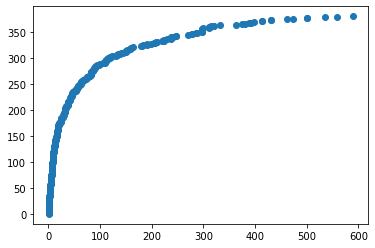

In [289]:
plt.scatter(T,Y)

### On va désormais faire la fonction qui à partir d'une adresse renvoie le noeud qui lui correspond

In [7]:
def quel_noeud(adresse, ville, nodes): 
    """
    Une adresse est de la forme : 270 rue saint Jacques 
    Une ville est de la forme : Paris 
    Ces deux entrées sont sous la forme de chaine de carcatères. 
    """
    requete = ""
    for lettre in adresse: 
        if lettre == " ": 
            requete += "+"
        else : 
            requete += lettre 
    requete += "+"
    for lettre in ville: 
        if lettre == " ": 
            requete += "+"
        else : 
            requete += lettre 
    requete = "https://api-adresse.data.gouv.fr/search/?q=" + requete
    print(requete)
    texte = requests.get(requete)
    texte = json.loads(texte.text)
    coordonnées = texte['features'][0]['geometry']['coordinates']
    coordonneées = [coordonnées[1], coordonnées[0]]        

    d_min = 1000000
    for node in nodes : 
        if distanceGPS(nodes[node], coordonneées) <= d_min :
            mon_noeud = node 
            d_min = distanceGPS(nodes[node], coordonneées)
    return mon_noeud 



In [9]:
quel_noeud("46 boulevard saint michel", "Paris", Noeuds)

https://api-adresse.data.gouv.fr/search/?q=46+boulevard+saint+michel+Paris


'5'

In [11]:
Noeuds['5']

[48.84882351091871, 2.341725093555166]

# Il faut désormais trouver une manière plus efficace de trouver les noeuds 

La méthode de trajectoire aléatoire utilisée précédemment est peu efficace et mérite d'être améliorée. Il faut trouver une méthode pour trouver les itinéraires qui vont permettre de trouver les noeuds de la manière la plus efficace possible. 

$\\[10cm]$

# Partie VRPY 

Le but dans cette partie c'est de donner une liste d'adresses et que à partir de VRPY, on est en retour la liste de l'odre dans lequel il faudra alors effectuer les trajets. Il trouve donc la tournée à effectuer par tous les camions. 

On prendra pour tester cette fonction des tournées avec 5 camions qui doivent livrer à 50 adresses différentes, avec toutes des demandes qui diffèrent. 

In [12]:
"""
On fait dans un premier temps la fonction qui à partir d'une liste de noeuds renvoie tous itinéraires entre les noeuds en parlant "noeuds". 
Cette fonction produit une liste immense. (de la taille du nombre de noeuds * nombre de noeuds). 
Pour un quartier de la taille de la moitié du 5ème, on a environ 300 noeuds. Cela donne une liste de 90000 éléments. 
Chacun de ces 9000 éléments est en fait une liste d'environ 4/5 éléments (noeuds pour aller de i vers j). 
"""

def construction_matrices(nodes):
    """
    Cette fonction prend en entrée la liste des noeuds qui ont été prédéfinis. 
    Elle renvoie d'une part la matrice des itinéraires entre les noeuds et d'autre part la matrice des temps de trajet entre les noeuds. 
    """
    N_nodes = len(nodes)
    matrix_durations = np.zeros((N_nodes,N_nodes))
    liste_itineraires = []

    i = 0 
    for node_start in nodes : 
        liste_itineraires.append([])
        start_x = nodes[node_start][1] 
        start_y = nodes[node_start][0]
        print('i = ', i)
        j = 0
        for node_end in nodes :
            end_x = nodes[node_end][1] 
            end_y = nodes[node_end][0]
            texte = requests.get("https://wxs.ign.fr/essentiels/geoportail/itineraire/rest/1.0.0/route?resource=bdtopo-osrm&start=" + str(start_x) + "," + str(start_y) + "&end=" + str(end_x) + "," + str(end_y) + "&timeUnit=second")
            texte = json.loads(texte.text)
            itineraire = texte['geometry']['coordinates']
            duration = texte['duration']
            matrix_durations[i,j] = duration 
            for element in itineraire: 
                if round(element[0]) == 2 : 
                    p = element[0]
                    element[0] = element[1]
                    element[1] = p 
            itineraire_points = change(itineraire,  0.00025, 0.0002, 0.000225)

            #il va maintenant falloir modifier cela en une liste de noeud. 
            itineraire_noeuds = []
            node_courant = "-1"
            for point in itineraire_points:
                for node in nodes  : 
                    if node != node_courant and dist(point, nodes[node]) <= 0.00045 : 
                        itineraire_noeuds.append(node)
                        node_courant = node
            liste_itineraires[i].append(itineraire_noeuds)  #Donc liste_itineraires[i][j] c'est l'itineraire pour aller de i vers j en parlant en noeud. 
            j+=1
        i+=1 
    return liste_itineraires, matrix_durations

In [15]:
"""
On définit ces données en variables globales pour justement éviter d'avoir à les recalculer à chaque demande vrpy. 
"""

liste_iti_noeuds, matrix_durations = construction_matrices(Noeuds)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
i =  20
i =  21
i =  22
i =  23
i =  24
i =  25
i =  26
i =  27
i =  28
i =  29
i =  30
i =  31
i =  32
i =  33
i =  34
i =  35
i =  36
i =  37
i =  38
i =  39
i =  40


In [41]:
def vrpy_trouver_tournée(adresses_et_demandes, nodes, capacités):
    
    """
    Nodes c'est notre liste de noeuds que l'on aura donc bien prédéfinie. La première étape va consister à atribuer à toutes les adresses le noeud leur correspondant. 
    adresses_et_demandes c'est un dictionnaire : chacune des clés est pour une adresse. pour chaque adresse on a donc une liste d'un élément : un dictionnaire 
    où l'on va retrouver toutes les infos necssaires pour l'adresse en question. 

    Capacité, c'est le nombre de camion que l'on a à notre disposition pour effectuer les tournées dans le quartier. 

    """

    noeuds_et_demandes = {}
    for adresse in adresses_et_demandes: 
        noeud = quel_noeud(adresse, "Paris", nodes)
        if noeud not in noeuds_et_demandes: 
            noeuds_et_demandes[noeud] = [{'demande' : adresses_et_demandes[adresse][0]['demande']}]
        else : 
            noeuds_et_demandes[noeud][0]['demande'] += adresses_et_demandes[adresse][0]['demande']
    print(noeuds_et_demandes)
    
    """
    On a désormais converti notre dictionnaire des demandes des adresses en un dictionnaire de demandes reportée sur les noeuds. 
    Il faut désormais établir les tournées. On va vouloir renvoyer à la suite (même si plusieurs tournées sont effectuées en parallèle) la grande liste 
    qui contient tous les noeuds que l'on va visiter dans l'odre (c'est la concaténation de toutes les tournées)
    """

    G = DiGraph()
    for noeud in noeuds_et_demandes : # ici on crée les edges entre les noeuds et le début / la fin qui est au noeud 0. 
        G.add_edge('Source', noeud, cost = [matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1],matrix_durations[0,eval(noeud)-1]])
        G.add_edge(noeud, 'Sink', cost = [matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0],matrix_durations[eval(noeud)-1,0]])
        G.nodes[noeud]["demand"] = noeuds_et_demandes[noeud][0]['demande']
    for start in noeuds_et_demandes: 
        for ending in noeuds_et_demandes:
            G.add_edge(start, ending, cost = [matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1],matrix_durations[eval(start)-1,eval(ending)-1]])
    prob = VehicleRoutingProblem(G, mixed_fleet=True, load_capacity=capacités)
    return prob
    

In [38]:
adresses_et_demandes = {}

for k in range(100): 
    rues = {'1' : "val de grace", '2' : "soufflot", '3' : "cujas", '4' : "gay lussac"}
    rue = rues[str(rd.randint(1,4))]
    if rue == "val de grace": 
        numero = rd.randint(1,20)
    elif rue == "soufflot": 
        numero = rd.randint(1,23)
    elif rue == "cujas": 
        numero = rd.randint(1,25)
    elif rue == 'gay lussac': 
        numero = rd.randint(1,66)
    demande = rd.randint(1,2)
    adresses_et_demandes[str(numero) + " rue " + rue] = [{'demande' : demande}]

adresses_et_demandes


{'8 rue val de grace': [{'demande': 1}],
 '18 rue gay lussac': [{'demande': 2}],
 '8 rue soufflot': [{'demande': 2}],
 '21 rue cujas': [{'demande': 2}],
 '10 rue soufflot': [{'demande': 2}],
 '4 rue cujas': [{'demande': 1}],
 '61 rue gay lussac': [{'demande': 2}],
 '19 rue cujas': [{'demande': 2}],
 '12 rue soufflot': [{'demande': 2}],
 '47 rue gay lussac': [{'demande': 2}],
 '7 rue gay lussac': [{'demande': 1}],
 '18 rue soufflot': [{'demande': 2}],
 '12 rue cujas': [{'demande': 2}],
 '21 rue soufflot': [{'demande': 2}],
 '1 rue soufflot': [{'demande': 2}],
 '29 rue gay lussac': [{'demande': 1}],
 '50 rue gay lussac': [{'demande': 2}],
 '12 rue val de grace': [{'demande': 1}],
 '31 rue gay lussac': [{'demande': 2}],
 '2 rue soufflot': [{'demande': 1}],
 '20 rue gay lussac': [{'demande': 1}],
 '14 rue val de grace': [{'demande': 1}],
 '16 rue val de grace': [{'demande': 1}],
 '5 rue val de grace': [{'demande': 1}],
 '17 rue soufflot': [{'demande': 2}],
 '11 rue val de grace': [{'demand

In [42]:
"""
On aura donc exécuté la cellule qui donne actuellement 42 noeuds. Puis la cellule qui calcule matrix durations etc... 
"""

prob = vrpy_trouver_tournée(adresses_et_demandes, Noeuds, [7,8,9,15,6])
prob.solve()

https://api-adresse.data.gouv.fr/search/?q=8+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=18+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=8+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=21+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=10+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=4+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=61+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=19+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=12+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=47+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=7+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=18+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=12+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=21+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=1+rue+soufflot+Paris
https://api-adresse.data.gouv.

INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:iteration 0, 3095.3
INFO:vrpy.vrp:iteration 1, 2674.3
INFO:vrpy.vrp:iteration 2, 2518.7
INFO:vrpy.vrp:iteration 3, 2518.7
INFO:vrpy.vrp:iteration 4, 2518.7


{'33': [{'demande': 11}], '23': [{'demande': 9}], '2': [{'demande': 12}], '30': [{'demande': 9}], '34': [{'demande': 4}], '8': [{'demande': 4}], '38': [{'demande': 8}], '16': [{'demande': 4}], '14': [{'demande': 1}], '40': [{'demande': 9}], '6': [{'demande': 2}], '31': [{'demande': 9}], '1': [{'demande': 3}], '32': [{'demande': 6}], '15': [{'demande': 4}], '11': [{'demande': 1}], '5': [{'demande': 1}], '12': [{'demande': 1}]}


INFO:vrpy.vrp:iteration 5, 2503.9
INFO:vrpy.vrp:iteration 6, 2276.2
INFO:vrpy.vrp:iteration 7, 2276.2
INFO:vrpy.vrp:iteration 8, 2276.2
INFO:vrpy.vrp:iteration 9, 2276.2
INFO:vrpy.vrp:iteration 10, 2276.2
INFO:vrpy.vrp:iteration 11, 2276.2
INFO:vrpy.vrp:iteration 12, 2252.7
INFO:vrpy.vrp:iteration 13, 2207.5
INFO:vrpy.vrp:iteration 14, 2207.5
INFO:vrpy.vrp:iteration 15, 2160.8
INFO:vrpy.vrp:iteration 16, 2160.8
INFO:vrpy.vrp:iteration 17, 2160.8
INFO:vrpy.vrp:iteration 18, 2160.8
INFO:vrpy.vrp:iteration 19, 2160.8
INFO:vrpy.vrp:iteration 20, 2143.2
INFO:vrpy.vrp:iteration 21, 2143.2
INFO:vrpy.vrp:iteration 22, 2143.2
INFO:vrpy.vrp:iteration 23, 2128.4
INFO:vrpy.vrp:iteration 24, 2113.4
INFO:vrpy.vrp:iteration 25, 2113.4
INFO:vrpy.vrp:iteration 26, 2113.4
INFO:vrpy.vrp:iteration 27, 2113.4
INFO:vrpy.vrp:iteration 28, 2113.4
INFO:vrpy.vrp:iteration 29, 2108.0
INFO:vrpy.vrp:iteration 30, 2108.0
INFO:vrpy.vrp:iteration 31, 2096.6
INFO:vrpy.vrp:iteration 32, 2075.3
INFO:vrpy.vrp:iteration 3

In [43]:
prob.best_routes

{1: ['Source', '2', 'Sink'],
 2: ['Source', '31', 'Sink'],
 3: ['Source', '1', 'Sink'],
 4: ['Source', '23', '11', '12', '16', 'Sink'],
 5: ['Source', '14', '15', '6', '38', 'Sink'],
 6: ['Source', '34', '33', 'Sink'],
 7: ['Source', '40', '32', 'Sink'],
 8: ['Source', '8', '30', '5', 'Sink']}

In [45]:
adresses_et_demandes = {}

for k in range(1000): 
    rues = {'1' : "val de grace", '2' : "soufflot", '3' : "cujas", '4' : "gay lussac"}
    rue = rues[str(rd.randint(1,4))]
    if rue == "val de grace": 
        numero = rd.randint(1,20)
    elif rue == "soufflot": 
        numero = rd.randint(1,23)
    elif rue == "cujas": 
        numero = rd.randint(1,25)
    elif rue == 'gay lussac': 
        numero = rd.randint(1,66)
    demande = rd.randint(1,2)
    adresses_et_demandes[str(numero) + " rue " + rue] = [{'demande' : demande}]

adresses_et_demandes

{'5 rue val de grace': [{'demande': 2}],
 '37 rue gay lussac': [{'demande': 2}],
 '16 rue cujas': [{'demande': 2}],
 '16 rue soufflot': [{'demande': 2}],
 '23 rue soufflot': [{'demande': 2}],
 '20 rue val de grace': [{'demande': 2}],
 '1 rue val de grace': [{'demande': 2}],
 '6 rue gay lussac': [{'demande': 1}],
 '22 rue cujas': [{'demande': 2}],
 '18 rue cujas': [{'demande': 2}],
 '17 rue gay lussac': [{'demande': 1}],
 '29 rue gay lussac': [{'demande': 1}],
 '3 rue soufflot': [{'demande': 1}],
 '19 rue cujas': [{'demande': 2}],
 '11 rue soufflot': [{'demande': 2}],
 '13 rue gay lussac': [{'demande': 1}],
 '30 rue gay lussac': [{'demande': 2}],
 '35 rue gay lussac': [{'demande': 1}],
 '13 rue cujas': [{'demande': 2}],
 '10 rue val de grace': [{'demande': 1}],
 '9 rue val de grace': [{'demande': 2}],
 '11 rue gay lussac': [{'demande': 1}],
 '39 rue gay lussac': [{'demande': 1}],
 '8 rue val de grace': [{'demande': 2}],
 '12 rue val de grace': [{'demande': 2}],
 '12 rue cujas': [{'deman

In [46]:
"""
On aura donc exécuté la cellule qui donne actuellement 42 noeuds. Puis la cellule qui calcule matrix durations etc... 
"""

prob = vrpy_trouver_tournée(adresses_et_demandes, Noeuds, [7,8,9,15,6])
prob.solve()

https://api-adresse.data.gouv.fr/search/?q=5+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=37+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=16+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=16+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=23+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=20+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=1+rue+val+de+grace+Paris
https://api-adresse.data.gouv.fr/search/?q=6+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=22+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=18+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=17+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=29+rue+gay+lussac+Paris
https://api-adresse.data.gouv.fr/search/?q=3+rue+soufflot+Paris
https://api-adresse.data.gouv.fr/search/?q=19+rue+cujas+Paris
https://api-adresse.data.gouv.fr/search/?q=11+rue+soufflot+Paris
https://api-adresse.d

ValueError: Demand 24 at node 33 larger than max capacity 15.